In [1]:
%matplotlib inline
from experiment import *
import numpy as np
import os

Using TensorFlow backend.


In [2]:
nclass = 3
#img_shape = (256, 256, 3)
img_shape = (512, 512, 3)

#m =  vgg_segnet(nclass, img_shape)

In [3]:
def generate_samples2(xpaths, ypaths, batch_size, train=False):
    batch_size = batch_size
    #size = (256,256)
    size = (512, 512)

    #cars, road, none

    cweights = [14.259816, 1., 0.25325792]

    while 1:
        xpaths, ypaths = shuffle(xpaths, ypaths)
        nbatches =  len(xpaths) // batch_size
        
        for i in range(nbatches):
            sample_weights = []
            
            xs = xpaths[i * batch_size: i*batch_size + batch_size]
            ys = ypaths[i * batch_size: i*batch_size + batch_size]
            
            xdata = []
            ydata = []
            for n in range(len(xs)):
                ximg = cv2.imread(os.path.join(img_url, xs[n]))
                yimg = cv2.imread((os.path.join(label_url, ys[n])))
                
                ximg[hood_pixels_gl[0],hood_pixels_gl[1], :] = 0.
                                
                ximg = cv2.resize(ximg, size, cv2.INTER_NEAREST)
                #yimg = cv2.resize(yimg, size, cv2.INTER_NEAREST)
                
                hot_label, weight = process_label(yimg)
                hot_label = cv2.resize(hot_label, size, cv2.INTER_NEAREST)
                weight = cv2.resize(weight, size, cv2.INTER_NEAREST)
                
                ydata.append(hot_label)
                xdata.append(ximg)
                sample_weights.append(weight)

                #reflect 1
                ridx = np.random.choice(range(batch_size))
                
                if ridx == 0:
                    ximg = cv2.cvtColor(ximg, cv2.COLOR_BGR2YUV)
                    ximg[:,:,0] = cv2.equalizeHist(ximg[:,:,0])
                    ximg = cv2.cvtColor(ximg, cv2.COLOR_YUV2BGR)
                    
                reflect_img = cv2.flip(ximg, 1)
                reflect_label = cv2.flip(hot_label, 1)
                reflect_weight = cv2.flip(weight, 1)
                xdata.append(reflect_img)
                ydata.append(reflect_label)
                sample_weights.append(reflect_weight)

            xdata = np.array(xdata).astype("float")
            xdata = xdata/255.# - 0.5
            #ydata = np.array(ydata).reshape( (batch_size, 600*800, 3))
            #print(np.array(ydata).shape)
            ydata = np.array(ydata).reshape( (batch_size * 2, size[0]*size[1], 3))
            sample_weights = np.array(sample_weights).reshape( (batch_size * 2, size[0]*size[1]))

            if not train:
                yield xdata, ydata
            else:
                yield xdata, ydata, np.array(sample_weights)

In [4]:
def run2():
    #metrics = Metrics2()
    
    batch_size=1
    #img_size = 
    
    xdata =  os.listdir(img_url)
    ylabel = os.listdir(label_url)
    
    #xtrain, xtest, ytrain, ytest = train_test_split(xdata, ylabel, test_size=0.2)
    xtrain, xtest, ytrain, ytest = train_test_split(xdata, ylabel, test_size=0.0)
    train_gen = generate_samples2(xtrain, ytrain, batch_size=batch_size, train=True)
    test_gen = generate_samples2(xtest, ytest, batch_size=batch_size)
    
    #imgsize = (600, 800, 3)
    model = vgg_segnet_concat(nclass, img_shape)
    runobj = model.fit_generator(train_gen,
                                samples_per_epoch= len(xtrain)//batch_size * batch_size * 2,
                                nb_epoch=9,
                                #validation_data=test_gen, 
                                nb_val_samples = (len(xtest)//batch_size) * batch_size,
                                nb_worker=1,
                                verbose=1)
        
    model.save("m_vggsegnet_concat_decov")
    
    return runobj, model

In [5]:
hist, m = run2()

Epoch 1/9
2000/2000 [==============================] - 992s - loss: 0.1224 - categorical_accuracy: 0.9212   
Epoch 2/9
2000/2000 [==============================] - 990s - loss: 0.0328 - categorical_accuracy: 0.9916   
Epoch 3/9
2000/2000 [==============================] - 987s - loss: 0.0222 - categorical_accuracy: 0.9949   
Epoch 4/9
2000/2000 [==============================] - 986s - loss: 0.0183 - categorical_accuracy: 0.9957   
Epoch 5/9
2000/2000 [==============================] - 990s - loss: 0.0164 - categorical_accuracy: 0.9962   
Epoch 6/9
2000/2000 [==============================] - 994s - loss: 0.0152 - categorical_accuracy: 0.9964   
Epoch 7/9
2000/2000 [==============================] - 995s - loss: 0.0144 - categorical_accuracy: 0.9966   
Epoch 8/9
2000/2000 [==============================] - 998s - loss: 0.0137 - categorical_accuracy: 0.9968   
Epoch 9/9
2000/2000 [==============================] - 1001s - loss: 0.0132 - categorical_accuracy: 0.9969  


# hist, m = run2()

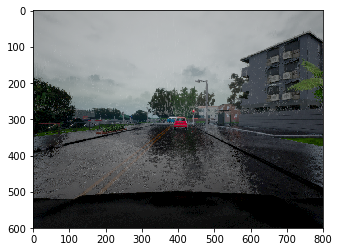

In [39]:
f = np.random.choice(os.listdir(label_url))
img = cv2.imread(os.path.join(img_url, f))
label = cv2.imread(os.path.join(label_url, f))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

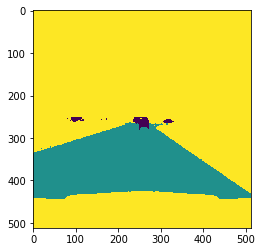

In [40]:
#test_x = np.zeros((1, 256, 256, 3)).astype('float')
test_x = np.zeros((1, 512, 512, 3)).astype('float')
img[hood_pixels_gl[0], hood_pixels_gl[1],:] = 0
img = cv2.resize(img, (512, 512))
test_x[0, :, : ,: ] = img
test_x = test_x/255.# - 0.5
#model = load_model("m2")
test_sample = m.predict(test_x)
final = test_sample.argmax(axis=2).reshape((512, 512)).astype('float')
#plt.imshow(cv2.resize(final, (800,600), cv2.INTER_NEAREST))
plt.imshow(final)

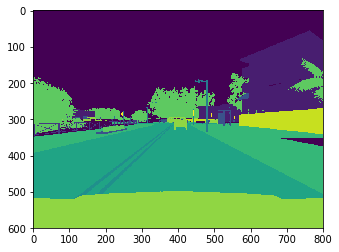

In [41]:
plt.imshow(label[:,:,2])

# Try segnet concat

In [ ]:
m =  vgg_segnet_concat(3, (256,256, 3))

In [ ]:
m.summary()


In [ ]:
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
img2 = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

plt.imshow(img2)

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))